# Histogram and Relative Likelihood Plotter

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy import stats
from itertools import chain, combinations
import math

from mpl_toolkits.axes_grid1.inset_locator import inset_axes
import matplotlib.animation as animation
import matplotlib.gridspec as gridspec
import matplotlib.colors as mcolors

from datetime import datetime
import os
import glob
import sys
module_path = os.path.abspath(os.path.join('../..'))
if module_path not in sys.path:
    sys.path.append(module_path)
    
from bkgndLibs.PINEM import *
from bkgndLibs.electronFns import *
from bkgndLibs.T_modes_cylinder import *

from itertools import product

In [2]:
import h5py
h5py.__version__

'2.10.0'

In [3]:
savedir = r'/storage/work/rjm6826/data/*.h5' # * means all if need specific format then *.csv
# savedir = r'/storage/group/mzc267/default/rjm6826/data/*.h5' # * means all if need specific format then *.csv
list_of_files = glob.glob(savedir) 
list_of_files = sorted(list_of_files, key=os.path.getmtime)
# list_of_files = [f for f in list_of_files if 'nDProbDensHist' in f]
list_of_files = [f for f in list_of_files if 'nDCalcLikeHist' in f]
# savefile = max(list_of_files, key=os.path.getctime)
# savefile = max(list_of_files, key=os.path.getmtime)
savefile = list_of_files[-1]
savefile

# savefile = r'/storage/home/rjm6826/data/tcav_061224_163138.h5'

'/storage/work/rjm6826/data/240605_nDCalcLikeHist.h5'

In [4]:
# with h5py.File(savefile, 'r') as hf:
#     print(hf.keys())
#     print(hf['nDHist'][:].shape)

with h5py.File(savefile, 'r') as hf:
#     meas_in = np.zeros(hf['nDHist'][:].shape)
#     meas_in = np.copy(hf['nDHist'][:])

#     means = np.copy(hf['means'])
#     nbins = np.copy(hf['nbins'])
#     bins_g2 = np.copy(hf['bins_g2'])
#     bins_n2 = np.copy(hf['bins_n2'])
#     bins_qmi = np.copy(hf['bins_qmi'])

    likelihood = np.copy(hf['Likelihood'])
    complike = np.copy(hf['Comp-Likelihood'])
    hist_storage = np.copy(hf['Histograms'])


    loaded_metadata = {key: hf['metadata'].attrs[key] for key in hf['metadata'].attrs}


In [17]:
loaded_metadata

{'E_range': '[0,-1]',
 'Electron energy range': 10000.0,
 'Enforce phase': False,
 'L_range': '[45,46]',
 'Lcav': 0.0001,
 'Maximum electron energy': 204117.50942468643,
 'Maximum time delay multiplier': 1.0,
 'Minimum time delay multiplier': 0.95,
 'Not a tensor product': True,
 'Number of cavities': 2,
 'Number of electron energies': 80,
 'Number of electrons': 1,
 'Number of free space lengths': 120,
 'Number of time delays': 1,
 'Phase maximum multiplier': 1.0,
 'Phase minimum multiplier': 0.01,
 'Phase reference': 1,
 'Save coupling?': False,
 'Save rho?': False,
 'alpha1': 0.5,
 'alpha2': 0.5,
 'author': 'Rick Mueller',
 'date': '24/06/05',
 'e_E_max_g': 199117.50942468643,
 'eps1': 3.581452955152137e-11,
 'eps2': 8.854187817e-12,
 'file_name': 't240605',
 'g2_bds': array([0.53858528, 1.08203097]),
 'l': 1,
 'm': 1,
 'm_measurements': 20000,
 'n2_bds': array([0.2351 , 0.89835]),
 'n_states': 15,
 'n_times': 10000,
 'name': 'Plane wave',
 'ndHist_date': '07/22/2024',
 'omega': 177

In [18]:
# Create save path
plot_file_umbrella = savefile.split(".")[0]

In [19]:
Es = np.linspace(loaded_metadata['Maximum electron energy'] - loaded_metadata['Electron energy range'], 
                 loaded_metadata['Maximum electron energy'], 
                 loaded_metadata['Number of electron energies'])
Lfree = np.linspace(loaded_metadata['Phase minimum multiplier']*loaded_metadata['Phase reference'], 
                    loaded_metadata['Phase maximum multiplier']*loaded_metadata['Phase reference'], 
                    loaded_metadata['Number of free space lengths'])
# Time delay (between cavity1 and cavity 2 photons)
t_delay_ref = Lfree / EnT_to_vvec(loaded_metadata['Maximum electron energy'],0,True)[2]

t_delay = np.zeros((loaded_metadata['Number of free space lengths'], 
                     loaded_metadata['Number of time delays']))


for i, l in enumerate(Lfree):
    t_delay[i,:] = np.linspace(loaded_metadata['Minimum time delay multiplier']*t_delay_ref[i],
                            loaded_metadata['Maximum time delay multiplier']*t_delay_ref[i],
                            loaded_metadata['Number of time delays'])

In [20]:
likelihood.shape

(79, 299, 1168)

In [21]:
meas_s = likelihood.shape[1:]
pset = powerset(meas_s)
pset = list(pset)[1:]
    
axes_to_sum = []
for i, p in enumerate(pset):
    p_tuple = tuple(p)
    
    condition = [index+1 for index, value in enumerate(meas_s) if value not in p]
    
    axes_to_sum.append(condition)
                        
    print(p_tuple, axes_to_sum) #, axes_to_sum[i])
     

(299,) [[2]]
(1168,) [[2], [1]]
(299, 1168) [[2], [1], []]


In [22]:
np.__version__

'1.20.1'

In [23]:
data = np.zeros(likelihood.shape[:2])
print(data.shape)

g2_ind = 0

denom = np.sum(hist_storage, axis=(0,) + tuple(axes_to_sum[g2_ind]))
denom = np.where(denom > 1e-16, denom, np.full_like(denom, 1e-16))

for i in range(likelihood.shape[0]):
    hist_i = np.sum(hist_storage[i], axis=tuple((1,)))
    data[i] = hist_i / denom
    
data = data.T

(79, 299)


/storage/work/rjm6826/data/240605_nDCalcLikeHist_g2_Hist_log.png


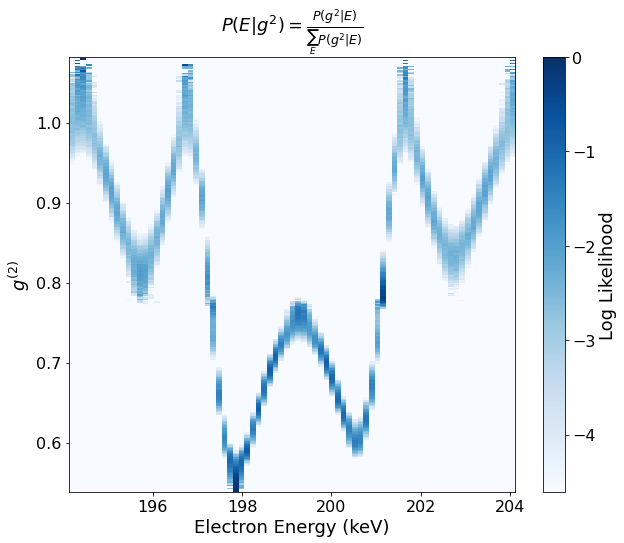

In [24]:
fig, ax = plt.subplots(1,1, figsize=(10,8))

ax.set_title(r'$P(E| g^2) = \frac{P(g^2|E)}{\sum_E P(g^2 |E)}$')
ax.set_xlabel('Electron Energy (keV)')
ax.set_ylabel(r"$ g^{(2)}$")

option='log'
# option='linear'

extent = extent=[Es[0]*1e-3, Es[-1]*1e-3,
                 loaded_metadata['g2_bds'][0],loaded_metadata['g2_bds'][1]]

# ax.plot(np.arange(likelihood.shape[0]), likelihood[:,0])

g2_ind = 0
# data = np.sum(likelihood, axis=tuple(axes_to_sum[g2_ind])).T * tbw

if option=='log':
    loglimit = 1e-2
    im = ax.imshow(np.log(data, out=np.full_like(data, np.log(loglimit)), 
                              where=(np.isclose(data, 0, atol=loglimit)!=True)), 
    #                vmax = 5e-2,
    #                vmax = 1e-1,
                   extent=extent,
                   origin='lower',aspect='auto', interpolation = 'None',
                  cmap='Blues')
elif option=='linear':
    im = ax.imshow(data, 
    #                vmin=1e0, vmax=1e4,
    #                vmax = 5e-2,
    #                vmax = 1e-1,
                   extent=extent,
                   origin='lower',aspect='auto', interpolation = 'None',
                  cmap='Blues')
# Colorbar
cbar = fig.colorbar(im, ax=ax)

if option=='log': cbar.set_label('Log Likelihood', size=18)
elif option=='linear':  cbar.set_label('Likelihood', size=18)
cbar.ax.tick_params(labelsize=16)

fontsizes2d(ax,18,16)

# Save File
PNGfile = plot_file_umbrella + r'_g2_Hist_{}.png'.format(option)
print(PNGfile)

fig.savefig(PNGfile, dpi=400, bbox_inches='tight')

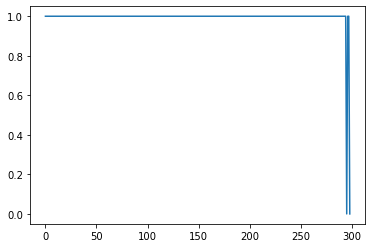

In [25]:
# Normalization check
plt.plot(np.sum(data, axis=1))

(79,) (80,)
(79,) (79,)


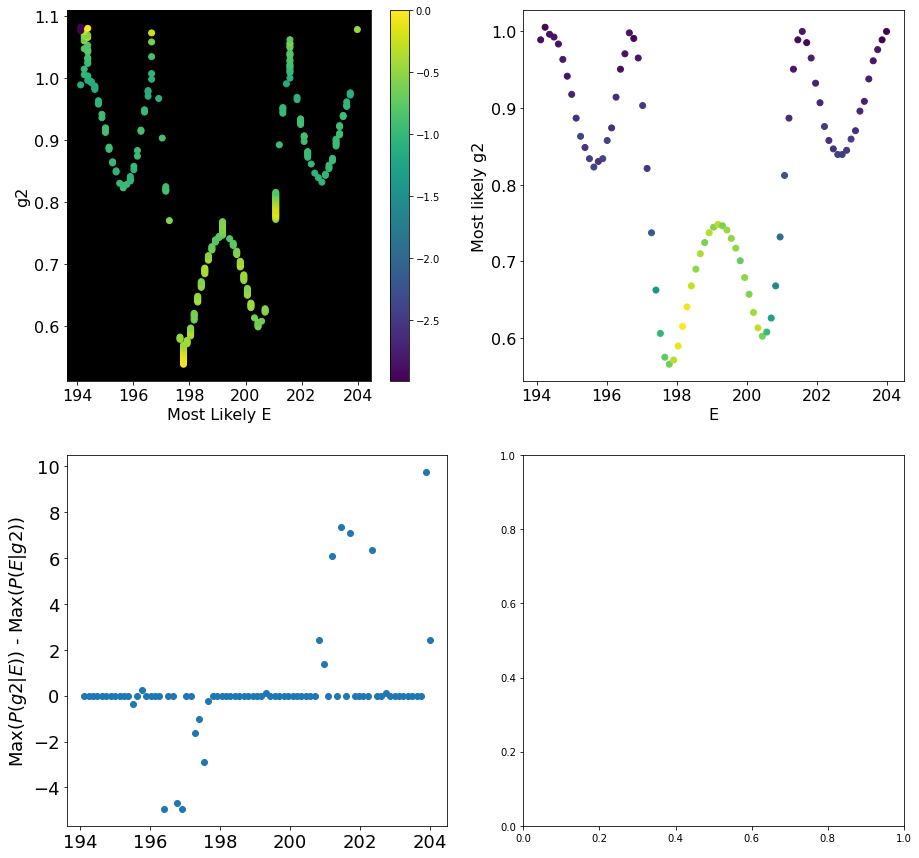

In [26]:
# Pick out the most likely E for each g2
maxEper_g2 = Es[data.argmax(axis=1)] * 1e-3

# Pick out the most likely g2 for each E
g2x = np.linspace(loaded_metadata['g2_bds'][0],loaded_metadata['g2_bds'][1], data.shape[0])
maxg2per_E = g2x[[np.argmax(np.sum(hist_i, axis=1)) for hist_i in hist_storage]]
print(maxg2per_E.shape, Es.shape)

figa, axa = plt.subplots(2,2, figsize=(15,15))

colors = np.amax(data, axis=1)
loglimit=(5e-2)
colors = np.log10(colors, out=np.full_like(colors, np.log(loglimit)), 
                                          where=(np.isclose(colors, 0, atol=loglimit)!=True))

res = axa[0,0].scatter(maxEper_g2, g2x, c=colors)
# axa.set_xlabel("g2"); axa.set_ylabel("Most Likely E")
axa[0,0].set_ylabel("g2"); axa[0,0].set_xlabel("Most Likely E")
axa[0,1].set_ylabel("Most likely g2"); axa[0,1].set_xlabel("E")

# Colorbar
cbar = fig.colorbar(res, ax=axa[0,0])

axa[0,0].set_facecolor('black')
fontsizes2d(axa[0,0], 16,16)

axa[0,1].scatter(Es[:-1]*1e-3, maxg2per_E, c=[np.amax(np.sum(hist_i, axis=1)) for hist_i in hist_storage])
fontsizes2d(axa[0,1], 16,16)
p3inds = np.array([np.where(np.isclose(g2x, x))[0] for x in maxg2per_E])[:,0]
plot3 = Es[:-1]*1e-3 - maxEper_g2[p3inds]

print(plot3.shape, p3inds.shape)
axa[1,0].scatter(Es[:-1]*1e-3, plot3)
axa[1,0].set_ylabel("Max$(P(g2|E))$ - Max$(P(E|g2))$")
fontsizes2d(axa[1,0], 18,18)

In [27]:
data = np.zeros(likelihood.shape[::2])
print(data.shape)

n2_ind = 1

denom = np.sum(hist_storage, axis=(0,) + tuple(axes_to_sum[n2_ind]))
denom = np.where(denom > 1e-16, denom, np.full_like(denom, 1e-16))

for i in range(likelihood.shape[0]):
    hist_i = np.sum(hist_storage[i], axis=tuple((0,)))
    data[i] = hist_i / denom
    
data = data.T

(79, 1168)


/storage/work/rjm6826/data/240605_nDCalcLikeHist_n2_Hist_linear.png


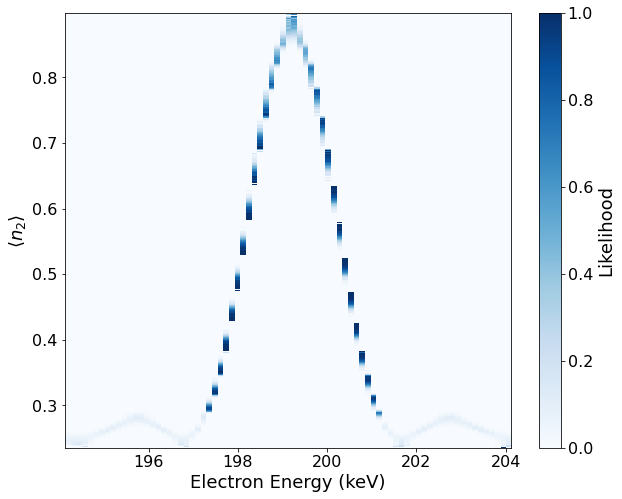

In [28]:
fig, ax = plt.subplots(1,1, figsize=(10,8))

# ax.set_title(r'$P(E| g^2) = \frac{P(g^2|E)}{\sum_E P(g^2 |E)}$')
ax.set_xlabel('Electron Energy (keV)')
ax.set_ylabel(r"$ \langle n_2 \rangle$")

option='log'
option='linear'

extent = extent=[Es[0]*1e-3, Es[-1]*1e-3,
                 loaded_metadata['n2_bds'][0],loaded_metadata['n2_bds'][1]]

# ax.plot(np.arange(likelihood.shape[0]), likelihood[:,0])

n2_ind = 1
# data = np.sum(likelihood, axis=tuple(axes_to_sum[n2_ind])).T

if option=='log':
    loglimit = 1e-3
    im = ax.imshow(np.log(data, out=np.full_like(data, np.log(loglimit)), 
                              where=(np.isclose(data, 0, atol=loglimit)!=True)), 
    #                vmax = 5e-2,
    #                vmax = 1e-1,
                   extent=extent,
                   origin='lower',aspect='auto', interpolation = 'None',
                  cmap='Blues')
elif option=='linear':
    im = ax.imshow(data, 
    #                vmin=1e0, vmax=1e4,
    #                vmax = 5e-2,
    #                vmax = 1e-1,
                   extent=extent,
                   origin='lower',aspect='auto', interpolation = 'None',
                  cmap='Blues')
# Colorbar
cbar = fig.colorbar(im, ax=ax)

if option=='log': cbar.set_label('Log Likelihood', size=18)
elif option=='linear':  cbar.set_label('Likelihood', size=18)
cbar.ax.tick_params(labelsize=16)

fontsizes2d(ax,18,16)

# Save File
PNGfile = plot_file_umbrella + r'_n2_Hist_{}.png'.format(option)
print(PNGfile)

fig.savefig(PNGfile, dpi=400, bbox_inches='tight')

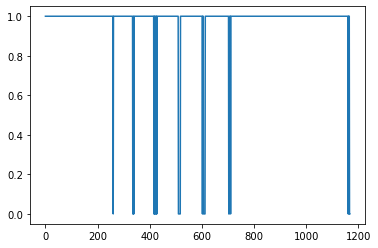

In [29]:
plt.plot(np.sum(data, axis=1))

## Finding the mode, and 95% confidence interval

In [30]:
data = np.zeros((likelihood.shape[0],) + (2,))
print(data.shape)

all_ind = 2

denom = np.sum(hist_storage, axis=(0,))
denom = np.where(denom > 1e-16, denom, np.full_like(denom, 1e-16))

for i in range(likelihood.shape[0]):
#     hist_i = np.sum(hist_storage[i], axis=tuple((0,1)))
    hist_i = hist_storage[i]
    temp = hist_i / denom
    
    # Find the indices of the mode (most probable value)
    mode_ind = np.unravel_index(np.argmax(temp, axis=None), temp.shape)
#     print(temp.shape)
    mode_val = mode_ind[0] #np.max(temp) #temp[mode_ind]
#     print(mode_ind)
    
    # Starting from the most likely index, 
    # iterate over the data set in all directions
    # until 95% of the probability is included. 
    
    prob_interval = len(temp[temp>.95])
    
    data[i] = [mode_val, prob_interval]
    
data = denom.T
# data = hist_storage[60].T

(79, 2)


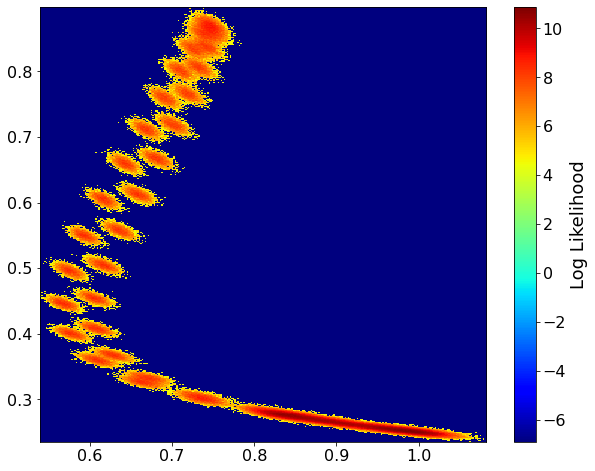

In [37]:
fig, ax = plt.subplots(1,1, figsize=(10,8))

option='log'
# option='linear'

extent = extent=[loaded_metadata['g2_bds'][0],loaded_metadata['g2_bds'][1],
                 loaded_metadata['n2_bds'][0],loaded_metadata['n2_bds'][1]]

if option=='log':
    loglimit = 1e-3
    im = ax.imshow(np.log(data, out=np.full_like(data, np.log(loglimit)), 
                              where=(np.isclose(data, 0, atol=loglimit)!=True)), 
    #                vmax = 5e-2,
#                    vmin = 6,
                   extent=extent,
                   origin='lower',aspect='auto', interpolation = 'None',
                  cmap='jet',
                  )
elif option=='linear':
    im = ax.imshow(data, 
    #                vmin=1e0, vmax=1e4,
    #                vmax = 5e-2,
    #                vmax = 1e-1,
                   extent=extent,
                   origin='lower',aspect='auto', interpolation = 'None',
#                   cmap='Blues',
                  )
# Colorbar
cbar = fig.colorbar(im, ax=ax)

if option=='log': cbar.set_label('Log Likelihood', size=18)
elif option=='linear':  cbar.set_label('Likelihood', size=18)
cbar.ax.tick_params(labelsize=16)

fontsizes2d(ax,18,16)

# Relative probabilities

In [63]:
title1 = r'$P(E_x| g^{(2)}) = \frac{P(g^{(2)}|E_x)}{P(g^{(2)} |E_x) + P(g^{(2)} |E_y)}$'
title2 = r'$P(E_x| \langle n_2 \rangle) = \frac{P(\langle n_2 \rangle|E_x)}{P(\langle n_2 \rangle |E_x) + P(\langle n_2 \rangle |E_y)}$'
title3 = r'$P(E_x| g^{(2)}) = \frac{P(g^{(2)},\langle n_2 \rangle|E_x)}{P(g^{(2)},\langle n_2 \rangle |E_x) + P(g^{(2)},\langle n_2 \rangle |E_y)}$'

titles = [title1, title2, title3]

/storage/group/mzc267/default/rjm6826/data/240605_nDCalcLikeHist_g2_n2_RelProb_linear.png


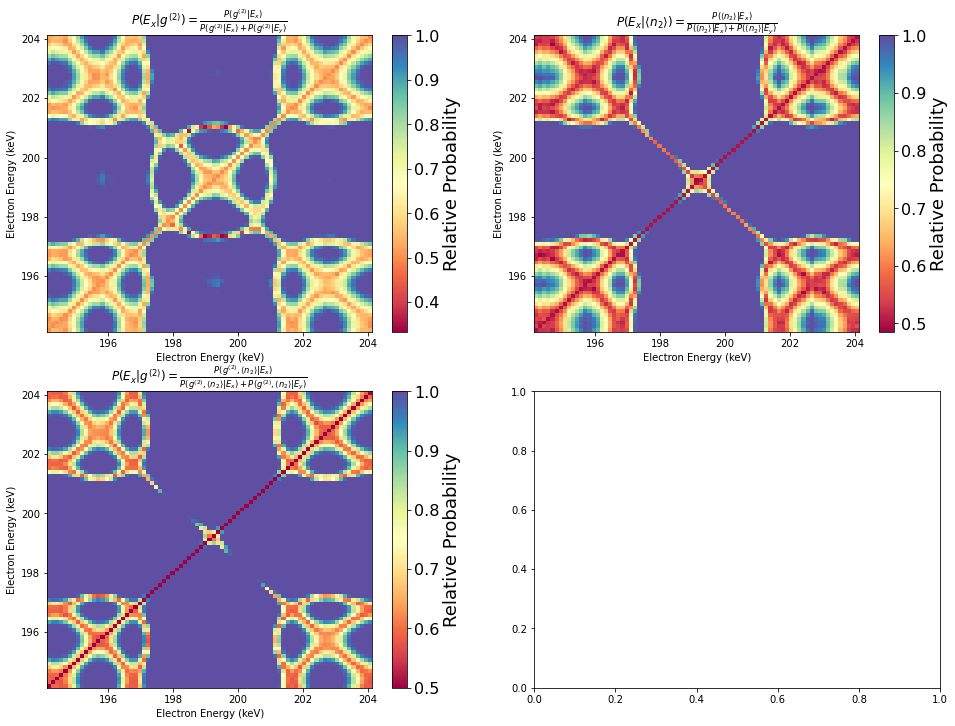

In [64]:
num_combs = math.ceil(np.sqrt(len(axes_to_sum)))
fig2, ax2 = plt.subplots(num_combs, num_combs, figsize=(16,12))

option='log'
option='linear'

cmap2 = None
cmap2 = 'Spectral'

extent = extent=[Es[0]*1e-3, Es[-1]*1e-3,
                 Es[0]*1e-3, Es[-1]*1e-3]

# ax.plot(np.arange(likelihood.shape[0]), likelihood[:,0])
for this_ax, axis in enumerate(axes_to_sum):
    data = complike[:,:,this_ax].T
    if option=='log':
    #     loglimit = 1e-2
        im = ax2[this_ax % 2, this_ax //2].imshow(np.log(data, out=np.full_like(data, np.log(loglimit)), 
                                  where=(np.isclose(complike.T, 0, atol=loglimit)!=True)), 
        #                vmax = 5e-2,
        #                vmax = 1e-1,
                       extent=extent,
                       origin='lower',aspect='auto', interpolation = 'None',
                      cmap=cmap2)
    elif option=='linear':
        im = ax2[this_ax // num_combs, this_ax % num_combs].imshow(data, 
    #     im = ax2.imshow(np.diag(np.diag(complike.T))*2, 
        #                vmin=1e0, vmax=1e4,
        #                vmax = 5e-2,
        #                vmax = 1e-1,
                       extent=extent,
                       origin='lower',aspect='auto', interpolation = 'None',
                      cmap=cmap2)
        
    cbar2 = fig2.colorbar(im, ax=ax2[this_ax // num_combs, this_ax % num_combs])
    if option=='log': cbar2.set_label('Log Relative Probability', size=18)
    elif option=='linear':  cbar2.set_label('Relative Probability', size=18)
    cbar2.ax.tick_params(labelsize=16)
    
    ax2[this_ax // num_combs, this_ax % num_combs].set_title(titles[this_ax])
    ax2[this_ax // num_combs, this_ax % num_combs].set_xlabel('Electron Energy (keV)')
    ax2[this_ax // num_combs, this_ax % num_combs].set_ylabel('Electron Energy (keV)')
#     Colorbar



# fontsizes2d(ax2,18,16)

# Save File
PNGfile = plot_file_umbrella + r'_g2_n2_RelProb_{}.png'.format(option)
print(PNGfile)

# fig2.savefig(PNGfile, dpi=400, bbox_inches='tight')

In [12]:
tbw = (loaded_metadata['g2_bds'][1] - loaded_metadata['g2_bds'][0]) / 301
print(tbw)
np.min(complike)*2

0.0018054673964926955


0.6660130446992893

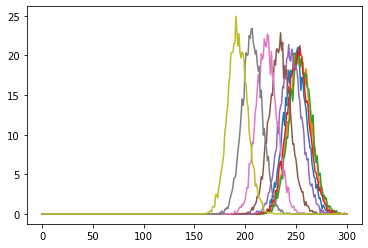

In [98]:
for i in range(likelihood.shape[0]-70):
    plt.plot(hist_storage[i])

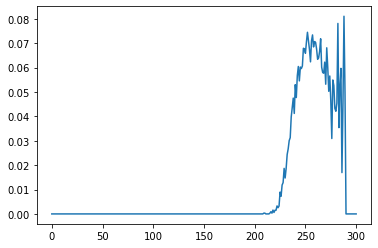

In [99]:
plt.plot(likelihood[0])

## Defining energy precision

In [100]:
bins_g2.shape

NameError: name 'bins_g2' is not defined

In [101]:
# Create save path
plot_file_umbrella = savefile.split(".")[0]

In [102]:
Lfree

array([0.01      , 0.01831933, 0.02663866, 0.03495798, 0.04327731,
       0.05159664, 0.05991597, 0.06823529, 0.07655462, 0.08487395,
       0.09319328, 0.10151261, 0.10983193, 0.11815126, 0.12647059,
       0.13478992, 0.14310924, 0.15142857, 0.1597479 , 0.16806723,
       0.17638655, 0.18470588, 0.19302521, 0.20134454, 0.20966387,
       0.21798319, 0.22630252, 0.23462185, 0.24294118, 0.2512605 ,
       0.25957983, 0.26789916, 0.27621849, 0.28453782, 0.29285714,
       0.30117647, 0.3094958 , 0.31781513, 0.32613445, 0.33445378,
       0.34277311, 0.35109244, 0.35941176, 0.36773109, 0.37605042,
       0.38436975, 0.39268908, 0.4010084 , 0.40932773, 0.41764706,
       0.42596639, 0.43428571, 0.44260504, 0.45092437, 0.4592437 ,
       0.46756303, 0.47588235, 0.48420168, 0.49252101, 0.50084034,
       0.50915966, 0.51747899, 0.52579832, 0.53411765, 0.54243697,
       0.5507563 , 0.55907563, 0.56739496, 0.57571429, 0.58403361,
       0.59235294, 0.60067227, 0.6089916 , 0.61731092, 0.62563

In [103]:
intm1 = np.array([(e, l, t) for e in Es \
                 for l, t_row in zip(Lfree, t_delay) \
                    for t in t_row])
# intm1

## Resolving g2, n2, and QMI

In [13]:
avg_g2 = np.zeros((meas_in.shape[0]))
avg_n2 = np.zeros((meas_in.shape[0]))
avg_qmi = np.zeros((meas_in.shape[0]))

bins_g2 = np.array([])
nbins_g2 = np.array([])
bins_n2 = np.array([])
nbins_n2 = np.array([])
bins_qmi = np.array([])
nbins_qmi = np.array([])


for ct, meas_outcomes in enumerate(meas_in):
#     print(meas_outcomes.shape)
    avg_g2[ct] = np.mean(meas_outcomes[0])
    avg_n2[ct] = np.mean(meas_outcomes[1])
    avg_qmi[ct] = np.mean(meas_outcomes[2])

    _, bins_g2ct = np.histogram(meas_outcomes[0], bins='fd', density=True)
    _, bins_n2ct = np.histogram(meas_outcomes[1], bins='fd', density=True)
    _, bins_qmict = np.histogram(meas_outcomes[2], bins='fd', density=True)
    
    bins_g2 = np.concatenate([bins_g2, bins_g2ct], axis=None)
    bins_n2 = np.concatenate([bins_n2, bins_n2ct], axis=None)
    bins_qmi = np.concatenate([bins_qmi, bins_qmict], axis=None)
    
    nbins_g2 = np.append(nbins_g2, bins_g2ct.shape[0], axis=None)
    nbins_n2 = np.append(nbins_n2, bins_n2ct.shape[0], axis=None)
    nbins_qmi = np.append(nbins_qmi, bins_qmict.shape[0], axis=None)
    
    


In [14]:
nbins_g2

array([15., 10., 11.,  7., 13., 11., 11.,  9., 16.,  8.,  9., 16., 12.,
        8., 12., 11.,  9., 18.,  9.,  9., 12., 10., 11., 10., 10., 12.,
       11., 17., 13., 11., 13., 17., 13., 10.,  9., 11.,  9., 14.,  9.,
       10.,  9.,  9., 10.,  8., 11.,  9., 16., 11., 13., 13., 12., 13.,
       12., 10., 10., 10., 20., 14., 11., 13., 11., 13., 13., 11., 16.,
       10., 12., 13., 15., 11., 10., 12., 14., 10., 10., 15., 13., 10.,
       14.,  2.,  2.,  2.,  2.,  2.,  2.,  2.,  2.,  2.,  2.,  2.,  2.,
        2.,  2.,  2.,  2.,  2.,  2.,  2.,  2.,  2.,  2.,  2.,  2.,  2.,
        2.,  2.,  2.,  2.,  2.,  2.,  2.,  2.,  2.,  2.,  2.,  2.,  2.,
        2.,  2.,  2.,  2.,  2.,  2.,  2.,  2.,  2.,  2.,  2.,  2.,  2.,
        2.,  2.,  2.,  2.,  2.,  2.,  2.,  2.,  2.,  2.,  2.,  2.,  2.,
        2.,  2.,  2.,  2.,  2.,  2.,  2.,  2.,  2.,  2.,  2.,  2.,  2.,
        2.,  2.,  2.,  2.,  2.,  2.,  2.,  2.,  2.,  2.,  2.,  2.,  2.,
        2.,  2.,  2.,  2.,  2.,  2.,  2.,  2.,  2.,  2.,  2.,  2

In [3]:
np.__version__

'1.20.1'

In [30]:
# Create meshgrid for g2 and n2
g2_centers = 0.5 * (bins_g2[:-1] + bins_g2[1:])
n2_centers = 0.5 * (bins_n2[:-1] + bins_n2[1:])
qmi_centers = 0.5 * (bins_qmi[:-1] + bins_qmi[1:])
g2_grid, n2_grid = np.meshgrid(g2_centers, n2_centers)

# Function to calculate the probability density
def calc_prob_density(g2, n2, qmi, bins_g2, bins_n2, bins_qmi):
    ndata = np.vstack([g2, n2, qmi]).T
    print(ndata.shape)
    hist_3d, edges = np.histogramdd(
        np.vstack([g2, n2, qmi]).T,
        bins=[bins_g2, bins_n2, bins_qmi],
        density=True
    )
    return hist_3d

# Calculate the 3D histogram for the given data
hist_3d = calc_prob_density(meas_outcomes[0], meas_outcomes[1], meas_outcomes[2], 
                            bins_g2, bins_n2, bins_qmi)

# Set up the figure and axis
# fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(12, 10), height_ratios=[3,1])
fig = plt.figure(constrained_layout=True, figsize=(12, 10))

# Define the grid
gs = gridspec.GridSpec(3, 1, figure=fig)

# Create the subplots
ax1 = fig.add_subplot(gs[0:2, :])
ax2 = fig.add_subplot(gs[2, :])


cax = ax1.imshow(hist_3d[:, :, 0], interpolation=None, 
                origin='lower', aspect='auto',
                extent=[g2_centers[0], g2_centers[-1], n2_centers[0], n2_centers[-1]],
                vmax=np.max(hist_3d))
fig.colorbar(cax)
ax1.set_xlabel('g2')
ax1.set_ylabel('n2')

# Function to update the heatmap for each frame
def update(frame):
    ax1.clear()
    ax2.clear()
    
    cax = ax1.imshow(hist_3d[:, :, frame], interpolation=None, 
                    origin='lower', aspect='auto',
                    extent=[g2_centers[0], g2_centers[-1], n2_centers[0], n2_centers[-1]],
                    vmax=np.max(hist_3d))
    ax1.set_title(f'QMI = {qmi_centers[frame]}')
    ax1.set_xlabel('g2')
    ax1.set_ylabel('n2')
    
    # Update the histogram
    ax2.bar(bins_qmi[:-1], hist_qmi, width=np.diff(bins_qmi), align='edge')
    ax2.axvline(qmi_centers[frame], color='r')  # Moving indicator
    ax2.set_xlabel('QMI')
    ax2.set_ylabel('Density')
    
    return cax,

# Create the animation
ani = animation.FuncAnimation(fig, update, 
                              frames=200, 
                              blit=False, repeat=True)

# Save the animation as an mp4 file
anifile = plot_file_umbrella \
                    + r'3axis_ntimes_{}_m_{}.gif'.format(n_times, m_measurements[0])
ani.save(anifile, writer='ffmpeg', fps=4, dpi=500)


(100, 9)


ValueError: The dimension of bins must be equal to the dimension of the  sample x.